Running simulation with 1 layers...
Number of layers 1
Step 0 out of 13
Step 5 out of 13
Step 10 out of 13
VQTE A List: [np.complex128(1+4.898587196589413e-16j), np.complex128(0.40247344950527975-4.640821434467212e-16j), np.complex128(0.49666813914248464+8.49793097749985e-16j), np.complex128(0.45408418285140334-4.783683817443376e-16j), np.complex128(0.47579489029416966+1.8326651684178156e-16j), np.complex128(0.4651041980989723+1.828022559434284e-16j), np.complex128(0.4704824011641275+1.8305680736487643e-16j), np.complex128(0.4678024850691038+1.8293527978957402e-16j), np.complex128(0.46914461448887124+1.8299746134299177e-16j), np.complex128(0.4684741080038014+1.8296672732443187e-16j), np.complex128(0.4688094988652902+1.8298218322805318e-16j), np.complex128(0.4686418380805148+1.8297447753637295e-16j), np.complex128(0.46872567710418367+1.8297833594265552e-16j), np.complex128(0.4686837597539421+1.8297640813019724e-16j)]
Exact A List: [np.complex128(1.0000000000000002-9.86076131526265e-32j)

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


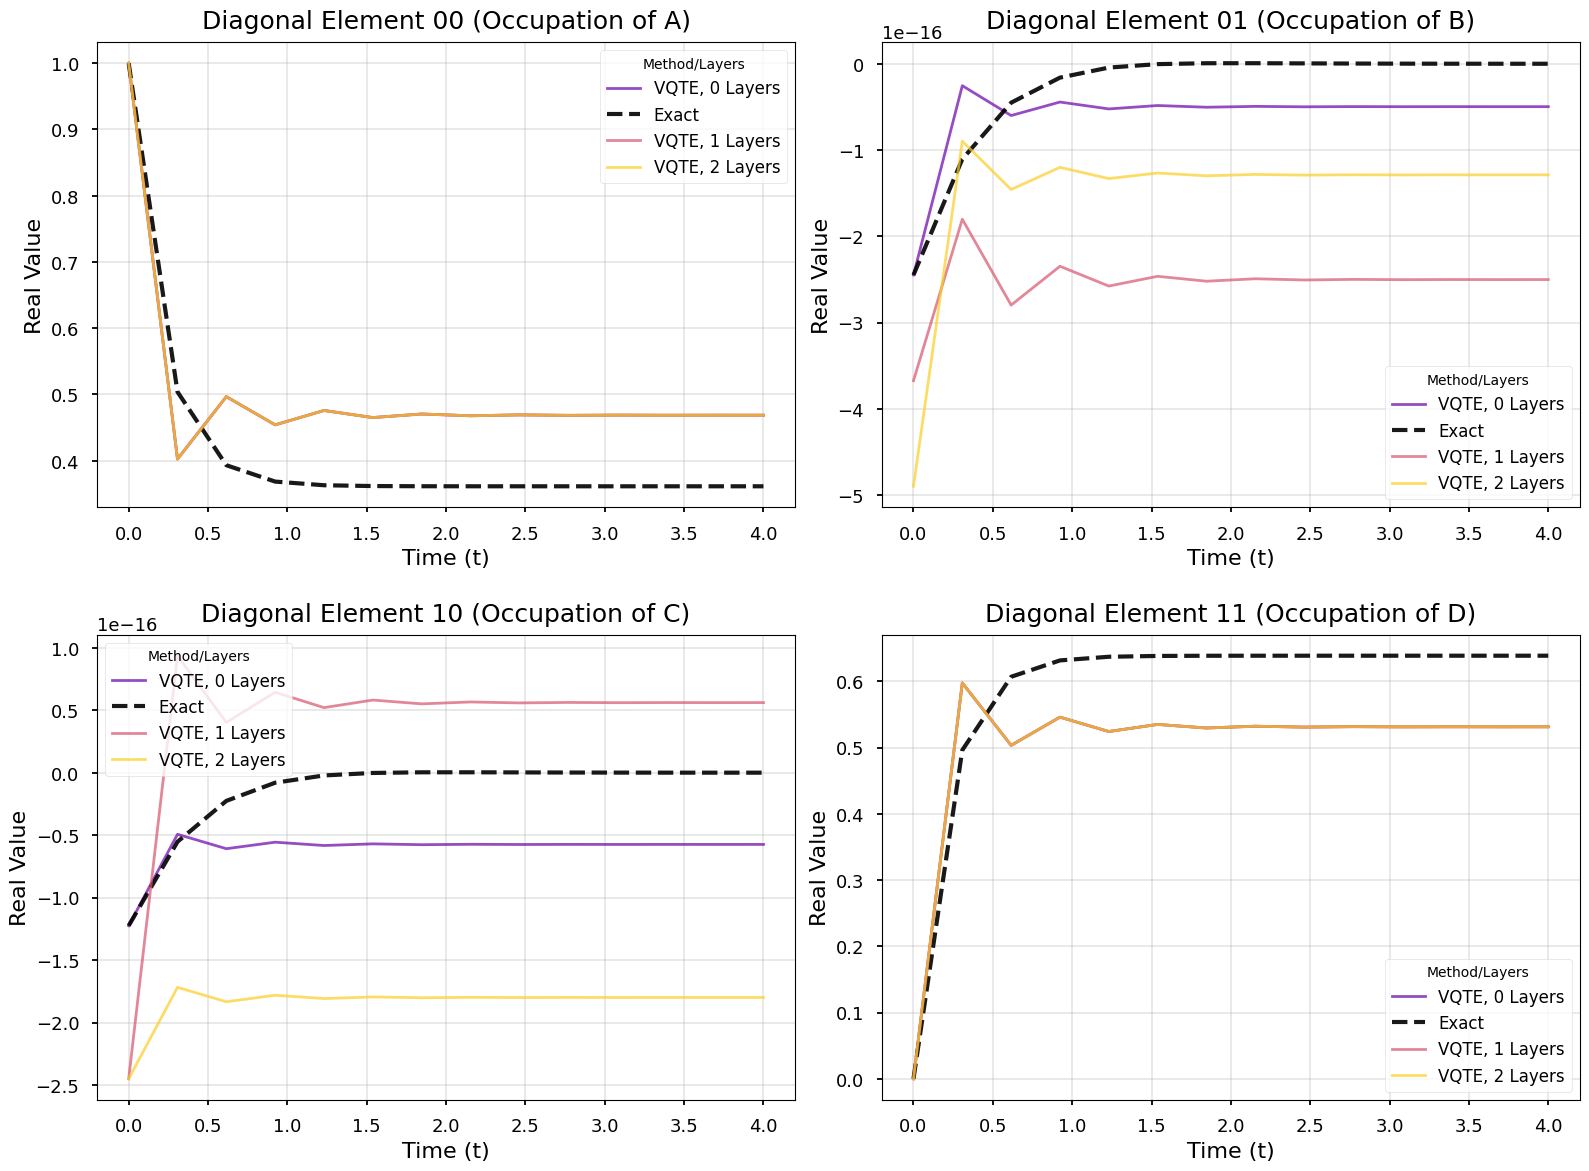

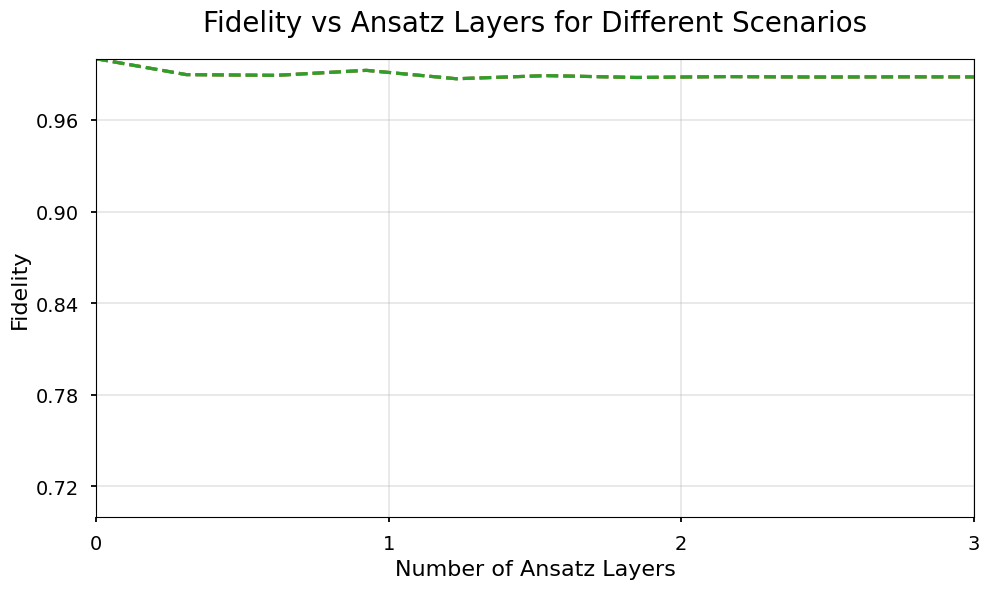

In [ ]:
from fidelity_main import run_multiple_layers


def main():
    run_multiple_layers(1)
    
main()


In [2]:
# # Initialize the simulation parameters
# def main():
#     gamma_L = 2
#     gamma_R = 3

#     eps = 1.0

#     mu_L= 1
#     mu_R= 2

#     # Temperature of Reserviors
#     T_L = 1
#     T_R= 1

#     time = 1.5
#     dt = 0.6
#     nt = int(time/dt)

#     beta_L=1/T_L
#     beta_R=1/T_R
#     F_L = 1/(np.exp(beta_L*(eps-mu_L))+1)
#     F_R = 1/(np.exp(beta_R*(eps-mu_R))+1)

#     # Generate Hamiltonians
#     exact_diag_ham = build_exact_diag_hamiltonian(eps)
#     ham_real, ham_imag = hamiltonian_generation(eps, gamma_L, gamma_R, F_R,F_L)



#     # Generate initial states
#     vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real)
#     print("VQTE Initial State : " , vqte_init_state)
#     print("Exact Initial : ", exact_diag_init_state)

#     # Perform exact diagonalization
#     exact_diag_results, time_points = perform_exact_diag(gamma_L, F_L, gamma_R, F_R, dt, nt, exact_diag_init_state, exact_diag_ham)

#     # Perform vqte simulation
#     vqte_results = perform_vqte(ham_real, ham_imag, vqte_init_state, dt, nt, ansatz, init_param_values)


#     output_results(
#     vqte_results, 
#     exact_diag_results, 
#     time_points, 
#     mu_L, T_L, gamma_L, 
#     mu_R, T_R, gamma_R)




# main()

# ## run multiple times with diff ansatz layers
# ## Get fidelity.
# ## Also save fidelity results to file
# ## Plot fidelity vs time for different ansatz layers
# ## Plot component by component comparison for different ansatz layers


Running simulation with 1 layers...
Number of layers 1
Step 0 out of 13
Step 5 out of 13
Step 10 out of 13
VQTE A List: [np.complex128(1+4.898587196589413e-16j), np.complex128(0.40247344950527975-4.640821434467212e-16j), np.complex128(0.49666813914248464+8.49793097749985e-16j), np.complex128(0.45408418285140334-4.783683817443376e-16j), np.complex128(0.47579489029416966+1.8326651684178156e-16j), np.complex128(0.4651041980989723+1.828022559434284e-16j), np.complex128(0.4704824011641275+1.8305680736487643e-16j), np.complex128(0.4678024850691038+1.8293527978957402e-16j), np.complex128(0.46914461448887124+1.8299746134299177e-16j), np.complex128(0.4684741080038014+1.8296672732443187e-16j), np.complex128(0.4688094988652902+1.8298218322805318e-16j), np.complex128(0.4686418380805148+1.8297447753637295e-16j), np.complex128(0.46872567710418367+1.8297833594265552e-16j), np.complex128(0.4686837597539421+1.8297640813019724e-16j)]
Exact A List: [np.complex128(1.0000000000000002-9.86076131526265e-32j)

c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\tessa\Documents\GitHub\open-quantum-systems-simulation\realsystemsreasearch\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


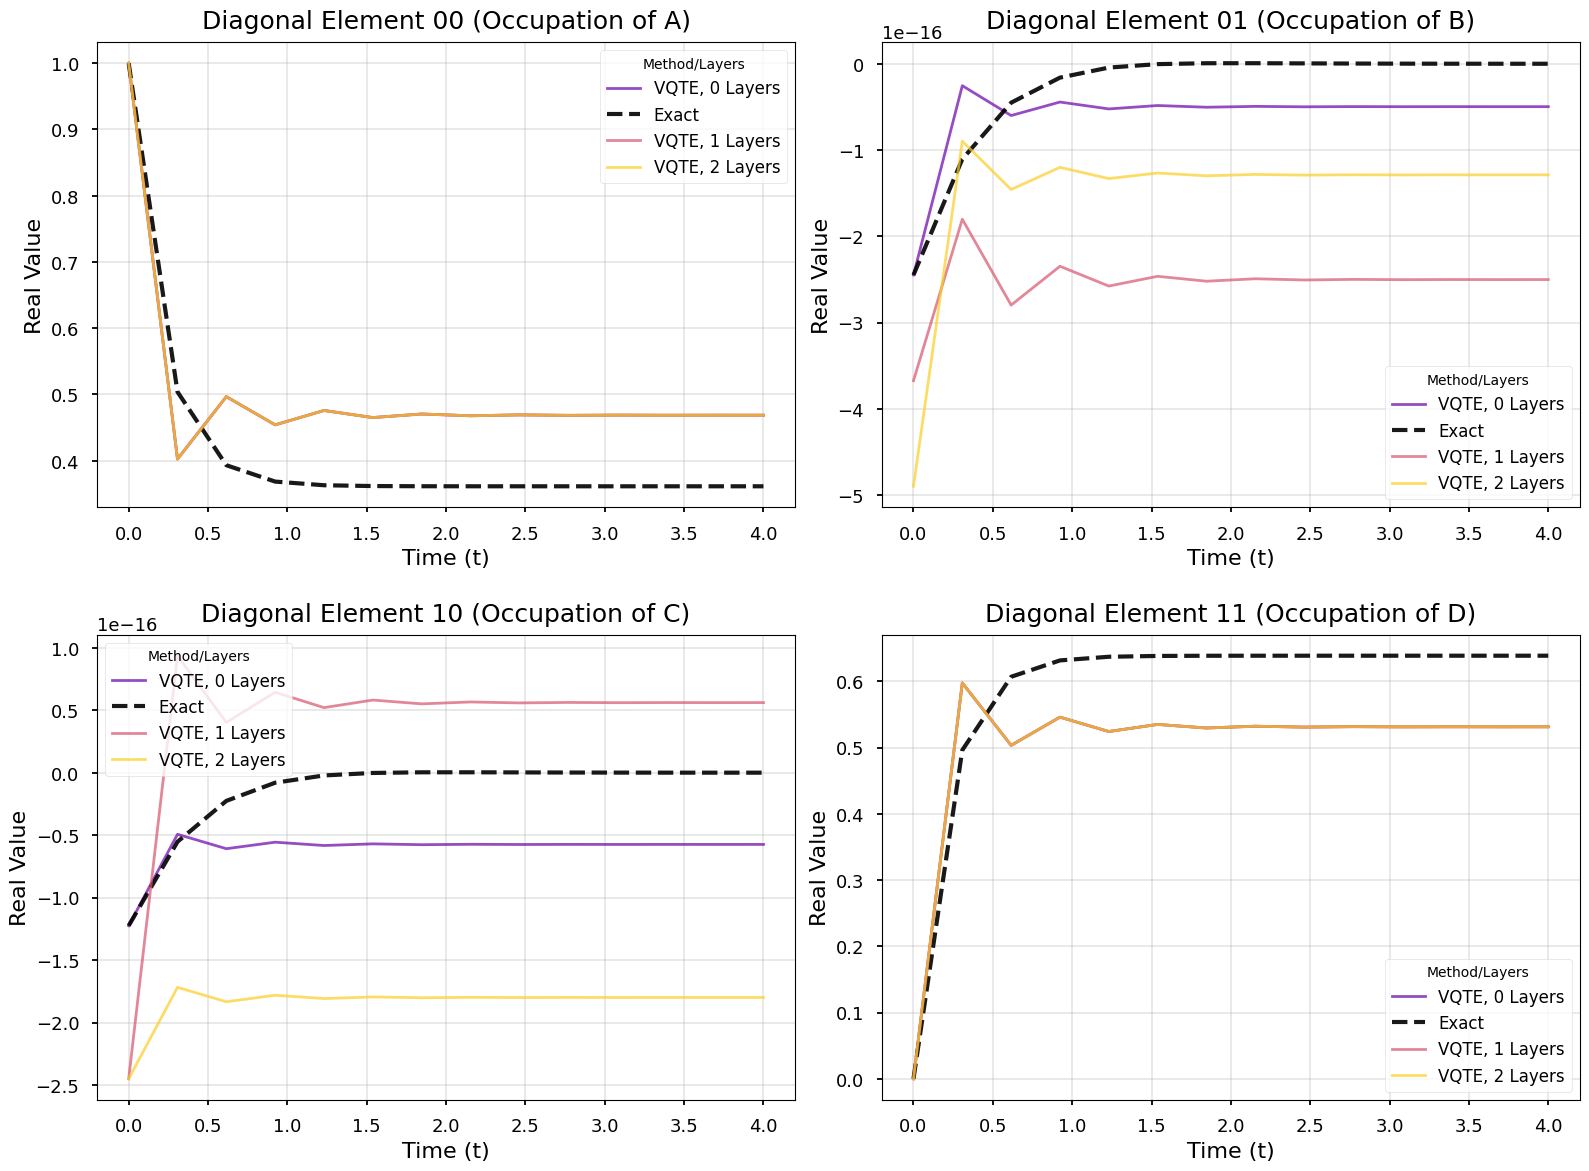

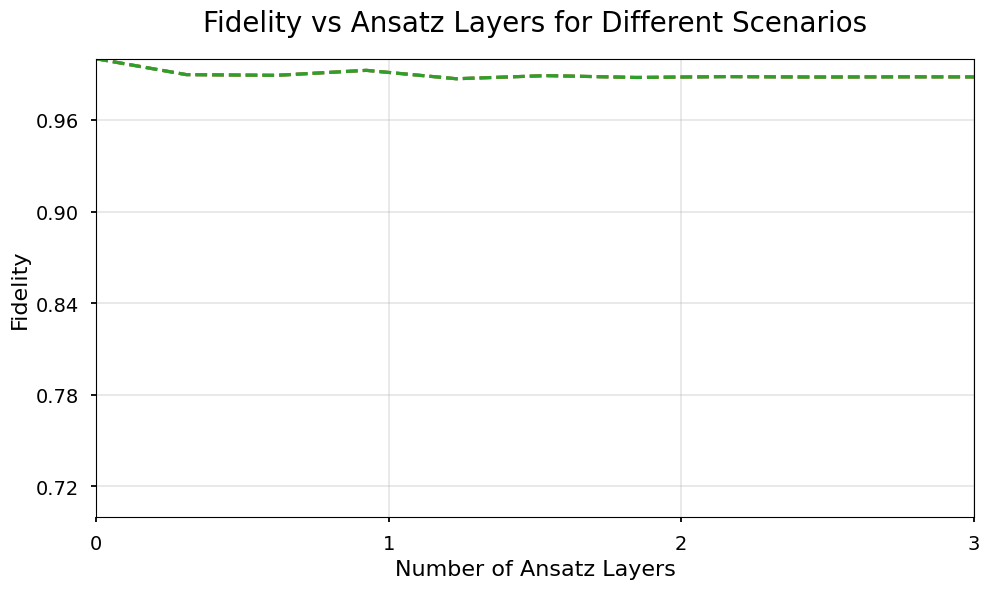

In [3]:
main()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

def save_fidelity_results(layers_list, fidelity_results, filename):
    """Saves fidelity vs layers results to file"""
    with open(filename, 'w') as f:
        f.write("Layers\tFidelity\n")
        for layers, fidelity in zip(layers_list, fidelity_results):
            f.write(f"{layers}\t{fidelity:.6f}\n")

def load_fidelity_results(filename):
    """Loads fidelity vs layers results from file"""
    layers_list = []
    fidelity_results = []
    with open(filename, 'r') as f:
        next(f)  # Skip header
        for line in f:
            layers, fidelity = map(float, line.strip().split('\t'))
            layers_list.append(int(layers))
            fidelity_results.append(fidelity)
    return layers_list, fidelity_results

def plot_fidelity_vs_layers(layers_list, fidelity_results, params):
    """
    Plots fidelity as a function of ansatz layers
    """
    plt.style.use('seaborn-v0_8-talk')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(layers_list, fidelity_results, 'o-', linewidth=2, markersize=8, color='#003594')
    
    ax.set_title("Fidelity vs Ansatz Layers", fontsize=20, pad=20)
    ax.set_xlabel("Number of Ansatz Layers", fontsize=16)
    ax.set_ylabel("Fidelity", fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    
    # Add parameter info
    params_text = (
        f"$\\gamma_L = {params['gamma_L']:.1f}$, $\\gamma_R = {params['gamma_R']:.1f}$\n"
        f"$\\mu_L = {params['mu_L']:.1f}$, $\\mu_R = {params['mu_R']:.1f}$\n"
        f"$T_L = {params['T_L']:.1f}$, $T_R = {params['T_R']:.1f}$\n"
        f"$\\Delta t = {params['dt']:.2f}$, Time = {params['time']:.1f}$"
    )
    
    ax.text(0.02, 0.98, params_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.8, boxstyle='round,pad=0.5'))
    
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.05)  # Fidelity ranges from 0 to 1
    plt.tight_layout()
    plt.show()


def run_multiple_layers():
    params = {
        'gamma_L': 2,
        'gamma_R': 3,
        'eps': 1.0,
        'mu_L': 1,
        'mu_R': 2,
        'T_L': 1,
        'T_R': 1,
        'time': 4,
        'dt': 0.1,
    }
    
    maxLayers = 6
    layers_list = list(range(1, maxLayers + 1))
    fidelity_results = []
    final_vqte_values = []
    final_exact_values = []
    
    os.makedirs('fidelity_results', exist_ok=True)
    
    for layers in layers_list:
        print(f"Running simulation with {layers} layers...")
        
        eps = params['eps']
        nt = int(params['time'] / params['dt'])
        
        beta_L = 1 / params['T_L']
        beta_R = 1 / params['T_R']
        F_L = 1 / (np.exp(beta_L * (eps - params['mu_L'])) + 1)
        F_R = 1 / (np.exp(beta_R * (eps - params['mu_R'])) + 1)
        
        exact_diag_ham = build_exact_diag_hamiltonian(eps)
        ham_real, ham_imag = hamiltonian_generation(eps, params['gamma_L'], params['gamma_R'], F_R, F_L)
        
        ansatz = EfficientSU2(ham_real.num_qubits, reps = layers)
        print('Number of layers', layers)
        # Build initial states with specified number of layers
        vqte_init_state, exact_diag_init_state, ansatz, init_param_values = build_initial_states(ham_real, ansatz)
        
        # Run simulations
        exact_diag_results, time_points = perform_exact_diag(
            params['gamma_L'], F_L, params['gamma_R'], F_R, 
            params['dt'], nt, exact_diag_init_state, exact_diag_ham
        )
        
        vqte_results = perform_vqte(
            ham_real, ham_imag, vqte_init_state, 
            params['dt'], nt, ansatz, init_param_values
        )
        all_time_fidelities = calculate_fidelity(vqte_results, exact_diag_results)
        
        
        # Get final values for fidelity calculation
        final_vqte = vqte_results[-1]
        final_exact = exact_diag_results[-1]
        
        final_vqte_values.append(final_vqte)
        final_exact_values.append(final_exact)
        
        # Calculate fidelity
        fidelity = calculate_fidelity(final_vqte, final_exact)
        fidelity_results.append(fidelity)
        
        print(f"Layers: {layers}, Fidelity: {fidelity:.4f}, VQTE final: {final_vqte:.4f}, Exact final: {final_exact:.4f}")
    
    # Save results
    fidelity_filename = f'fidelity_results/fidelity_vs_layers.txt'
    save_fidelity_results(layers_list, fidelity_results, fidelity_filename)
    
    # Also save detailed results for each layer
    detailed_filename = f'fidelity_results/detailed_results.txt'
    with open(detailed_filename, 'w') as f:
        f.write("Layers\tFidelity\tVQTE_Final\tExact_Final\n")
        for layers, fidelity, vqte, exact in zip(layers_list, fidelity_results, final_vqte_values, final_exact_values):
            f.write(f"{layers}\t{fidelity:.6f}\t{vqte:.6f}\t{exact:.6f}\n")
    
    # Plot results
    plot_fidelity_vs_layers(layers_list, fidelity_results, params)
    print(fidelity_results)
    
    return layers_list, fidelity_results

# Run the simulation
layers, fidelities = run_multiple_layers()

Running simulation with 1 layers...


NameError: name 'build_exact_diag_hamiltonian' is not defined